#### Import libraries

In [1]:
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Initialize image data genetator, specify dataset path and batch size

In [2]:
datagen = ImageDataGenerator(rescale=1/255)
dir = './Dataset/train'

batch_size = 32
image_size = 266

#### Create the image generator so that we only load one image at a time, preserving memory

In [3]:
generator = datagen.flow_from_directory(
    directory=dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 38496 images belonging to 85 classes.


#### Extract id and image size info from each image filename using regular expressions

In [4]:
labels = []
image_sizes = []

for filename in generator.filenames:
    image_size = str(re.findall("_[0-9]{3}_[0-9]{3}", filename))
    image_size = re.sub("_", "", image_size)
    
    image_width = int(image_size[2:5])
    image_height = int(image_size[5:8])
    
    image_size = (image_width, image_height)
    image_sizes.append(image_size)
    
    new_fn = re.sub("case([0-9]+)\\\\", "", filename)
    new_fn = re.sub("\\\\", "_", new_fn)
    new_fn = re.sub("_[0-9]{3}_[0-9]{3}_1.50_1.50.png", "", new_fn)

    labels.append(new_fn)

#### Display some images from the dataset

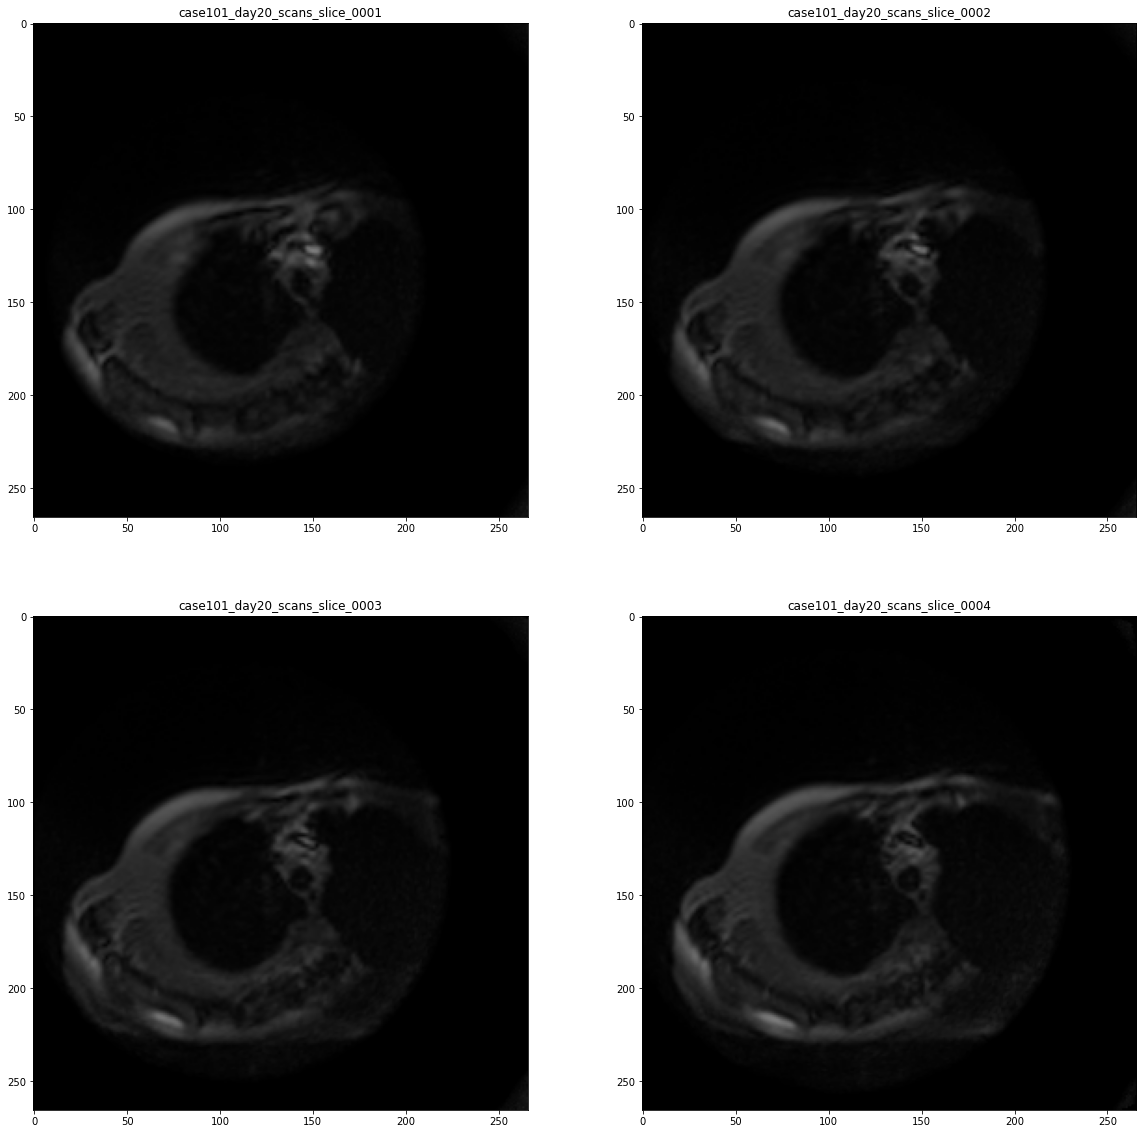

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

images = next(generator)

itr = 0
for i in range(2):
    for j in range(2):
        ax[i, j].imshow(images[itr])
        ax[i, j].title.set_text(labels[itr])
        itr += 1
        
plt.show()

## Each patient case has several days, and each day has many 'slices'. Each slice has 3 masks; a mask for the large bowel, small bowel and stomach

## There are 156 total training cases with about 5 days worth of data. Each day has 150 or so 'slices' or images

In [6]:
data_df = pd.read_csv('./Dataset/train.csv')
data_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


## Questions:
### Is every single image the same size?
### A: I do not think so, so we need to handle this somehow within our generator